<a href="https://colab.research.google.com/github/lostapple9/CovidLungDetectionModel/blob/main/Copy_of_covid_lung_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [247]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [248]:
import os
import gc
import random
import matplotlib.pyplot as plt
import numpy as np
from cv2 import resize, imread, IMREAD_COLOR, IMREAD_GRAYSCALE, INTER_CUBIC
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

covid_set = ['/content/drive/MyDrive/covid19_lung_data/{}'.format(i) for i in os.listdir('/content/drive/MyDrive/covid19_lung_data')]
normal_set = ['/content/drive/MyDrive/normal_lung_data/{}'.format(i) for i in os.listdir('/content/drive/MyDrive/normal_lung_data')]
patient_zero_unkown_set = ['/content/drive/MyDrive/patient_zero_unknow/{}'.format(i) for i in os.listdir('/content/drive/MyDrive/patient_zero_unknow')]

#put patient's x ray in the patient_zero_unkown_set dataset, in other words put it in the (content/drive/MyDrive/patient_zero_unknow) drive


In [249]:
print(normal_set)
print(covid_set)
print(patient_zero_unkown_set)

['/content/drive/MyDrive/normal_lung_data/Normal-10.png', '/content/drive/MyDrive/normal_lung_data/Normal-100.png', '/content/drive/MyDrive/normal_lung_data/Normal-1.png', '/content/drive/MyDrive/normal_lung_data/Normal-101.png', '/content/drive/MyDrive/normal_lung_data/Normal-103.png', '/content/drive/MyDrive/normal_lung_data/Normal-105.png', '/content/drive/MyDrive/normal_lung_data/Normal-106.png', '/content/drive/MyDrive/normal_lung_data/Normal-104.png', '/content/drive/MyDrive/normal_lung_data/Normal-102.png', '/content/drive/MyDrive/normal_lung_data/Normal-107.png', '/content/drive/MyDrive/normal_lung_data/Normal-111.png', '/content/drive/MyDrive/normal_lung_data/Normal-115.png', '/content/drive/MyDrive/normal_lung_data/Normal-108.png', '/content/drive/MyDrive/normal_lung_data/Normal-114.png', '/content/drive/MyDrive/normal_lung_data/Normal-112.png', '/content/drive/MyDrive/normal_lung_data/Normal-113.png', '/content/drive/MyDrive/normal_lung_data/Normal-109.png', '/content/drive/

In [250]:
total = normal_set + covid_set
random.shuffle(total)
random.shuffle(patient_zero_unkown_set)

In [251]:
split = 0.8
# slice_reserve = 9;
slice_reserve = len(patient_zero_unkown_set)
slice_total = len(normal_set)
slice_list_max = slice_total - slice_reserve
slice_list = int(slice_list_max*split)

train_set = total[:slice_list]
test_set = total[slice_list: slice_list_max]
# reserve_set = total[slice_list_max: slice_total]

reserve_set = patient_zero_unkown_set[0:slice_reserve]


In [252]:

del covid_set,normal_set,patient_zero_unkown_set
gc.collect()

24197

In [253]:
width = 250
height = 250



In [254]:
X_train = []
X_test = []
X_reserve = []

y_train = []
y_test = []
y_reserve = []


In [255]:
# a 0 label indicates positive covid pneumonia
# a 1 label indicates no pneumonia
def preprocess_image_set(data_set):
  X_set = []
  y_set = []
  for image in data_set:
    try:
      X_set.append(resize(imread(image), (width, height), interpolation = INTER_CUBIC))
      if 'COVID-' in image:
        y_set.append(0)
      else:
        y_set.append(1)
    except Exception:
      print('failed to format: ', image)
  return X_set, y_set

In [256]:
def show_images(image_set, label_set):
  plt.figure(figsize = (10,10))
  # for i in range(9):
  first_img = 0
  last_ima = 9
  for i in range(first_img,last_ima):
    ax = plt.subplot(3,3, i + 1 - first_img)
    plt.imshow(image_set[i])
    if label_set[i] == 0:
      plt.title("positive covid pneumonia")
    elif label_set[i] == 1:
      plt.title("no pneumonia")
    # plt.title(label_set[i])
    plt.axis("off")


In [257]:
X_train, y_train = preprocess_image_set(train_set)

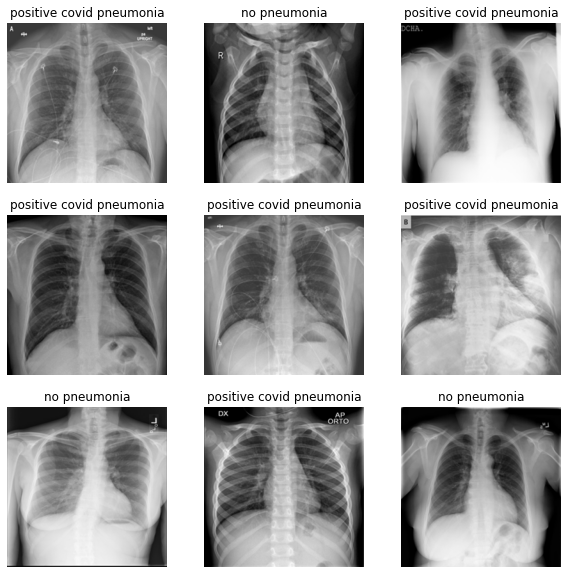

In [258]:
# show the first 9 images from training set
# update: show the first_img to the last_ima from training set
# a 0 label indicates positive covid pneumonia
# a 1 label indicates no pneumonia
show_images(X_train, y_train)

In [259]:
X_test, y_test = preprocess_image_set(test_set)

In [260]:
X_reserve, y_reserve = preprocess_image_set(reserve_set)

In [261]:
del train_set, test_set, reserve_set
gc.collect()

18192

In [262]:
# translate lists into numpy arrays
X_train =  np.array(X_train)
X_test = np.array(X_test)
X_reserve =  np.array(X_reserve)

y_train = np.array(y_train)
y_test = np.array(y_test)


In [263]:

model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation = 'relu', input_shape = (width, height,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size = 3, activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256, kernel_size = 3, activation = 'relu'))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(600, activation = 'relu'))
model.add(Dense(200, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [264]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 29, 29, 128)     

In [265]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [266]:
history = model.fit(X_train,y_train, validation_data = (X_test, y_test), epochs = 15)

Epoch 1/15
5/5 [==============================] - 2s 256ms/step - loss: 1340.5323 - accuracy: 0.4662 - val_loss: 16.8545 - val_accuracy: 0.5000
Epoch 2/15
5/5 [==============================] - 1s 192ms/step - loss: 8.6990 - accuracy: 0.5608 - val_loss: 0.9068 - val_accuracy: 0.5000
Epoch 3/15
5/5 [==============================] - 1s 192ms/step - loss: 3.5084 - accuracy: 0.4730 - val_loss: 6.9436 - val_accuracy: 0.5000
Epoch 4/15
5/5 [==============================] - 1s 192ms/step - loss: 3.7967 - accuracy: 0.6284 - val_loss: 8.3604 - val_accuracy: 0.5000
Epoch 5/15
5/5 [==============================] - 1s 194ms/step - loss: 3.8628 - accuracy: 0.5405 - val_loss: 0.6688 - val_accuracy: 0.7895
Epoch 6/15
5/5 [==============================] - 1s 192ms/step - loss: 1.0802 - accuracy: 0.7095 - val_loss: 0.5490 - val_accuracy: 0.7368
Epoch 7/15
5/5 [==============================] - 1s 191ms/step - loss: 0.3343 - accuracy: 0.8716 - val_loss: 0.6026 - val_accuracy: 0.7632
Epoch 8/15
5/5 [

In [267]:
history.history['accuracy']

[0.46621620655059814,
 0.5608108043670654,
 0.47297295928001404,
 0.6283783912658691,
 0.5405405163764954,
 0.7094594836235046,
 0.8716216087341309,
 0.9054054021835327,
 0.9054054021835327,
 0.8783783912658691,
 0.9189189076423645,
 0.9391891956329346,
 0.9594594836235046,
 0.8918918967247009,
 0.8581081032752991]

In [268]:
# make label predictions on unseen data
y_predict = model.predict(X_reserve[:slice_reserve])
y_pred = (y_predict > 0.5)

In [269]:
y_pred = y_pred.tolist()

In [270]:
y_predict = y_predict.tolist()
y_predict

[[0.998207688331604],
 [0.992394208908081],
 [0.9999556541442871],
 [0.915319561958313],
 [0.5099394917488098],
 [0.26556873321533203],
 [0.04366806522011757],
 [0.9999688863754272],
 [0.005902338773012161]]

In [271]:
y_reserve

[1, 1, 0, 1, 0, 1, 0, 1, 0]

In [272]:
for i in range(len(y_predict)):
  print("predicted result: %0.5f percent probability does not have covid" % (y_predict[i][0]*100))
  if(y_reserve[i] == 0):
    print("Actual result: has covid")
  else:
    print("Actual result: does not have covid")
  print()


predicted result: 99.82077 percent probability does not have covid
Actual result: does not have covid

predicted result: 99.23942 percent probability does not have covid
Actual result: does not have covid

predicted result: 99.99557 percent probability does not have covid
Actual result: has covid

predicted result: 91.53196 percent probability does not have covid
Actual result: does not have covid

predicted result: 50.99395 percent probability does not have covid
Actual result: has covid

predicted result: 26.55687 percent probability does not have covid
Actual result: does not have covid

predicted result: 4.36681 percent probability does not have covid
Actual result: has covid

predicted result: 99.99689 percent probability does not have covid
Actual result: does not have covid

predicted result: 0.59023 percent probability does not have covid
Actual result: has covid



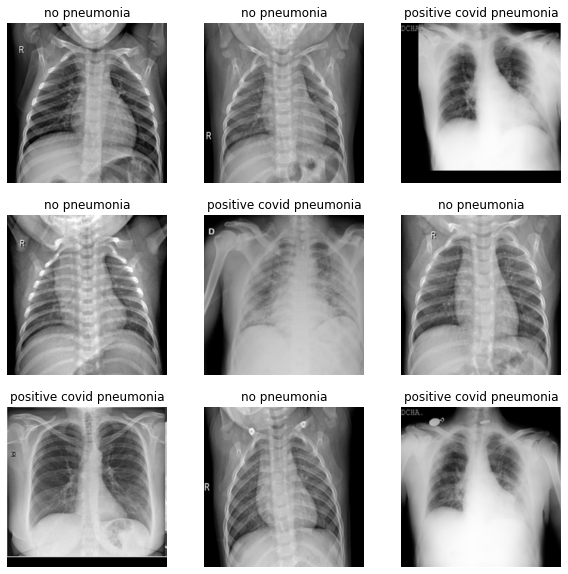

In [273]:
# show the images from reserve set
# 1 = no covid, 0 = covid

# change the slice_reserve for more pictures
show_images(X_reserve, y_reserve)

In [276]:
from sklearn.metrics import confusion_matrix

#event = has covid
#no-event = does not have covid
model_metric = confusion_matrix(y_reserve, y_pred)

In [277]:
accuracy = (model_metric[0][0] + model_metric[1][1])/ (sum(map(sum, model_metric)))
accuracy

0.6666666666666666